# Train part of the project
This notebook is here to show our pipeline of transformation of the training data and how we trained our models.  
## Package import


In [21]:
# OS
import os
# Data wrangling
import numpy as np
import pandas as pd

# Plot
import  matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

#Face datection and cropping

from tensorflow import keras
# Progress bar
from tqdm import tqdm

from numpy.random import seed
seed(1)

#Deep learning
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras import regularizers
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D,BatchNormalization,Dropout,Flatten,MaxPooling2D
from tensorflow.keras import Input
import tensorflow_addons as tfa
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1070, pci bus id: 0000:10:00.0, compute capability: 6.1



## Training sample description
### Fast description of the LFW dataset

100%|██████████| 5749/5749 [00:09<00:00, 624.86it/s] 


Number of identities  in the training set 5749
Number of images in the training set 13233
-----------------------------------------------------------------------


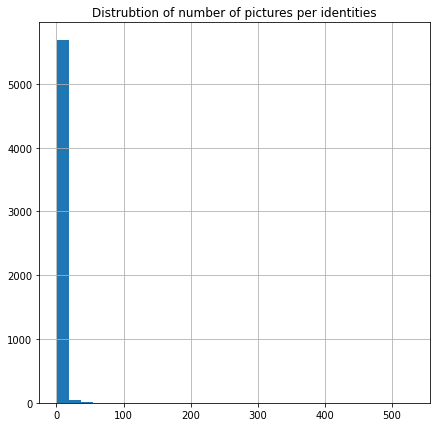

In [2]:
def create_correspondance_df(path_to_pictures):
    """
    Creates a correspondance dataframe (person, image_name) for a given dataset  
    args :
    path_to_pictures (str) : Path to folder where the pictures are located
    returns :
    correspondance_df (pd.DataFrame) : The DataFrame with correspondances
    """
    matrix = []
    all_identities  = os.listdir(path_to_pictures)
    cat = 0
    for identity in tqdm(all_identities[1:]):
        for picture in os.listdir(path_to_pictures + "/" + identity):
            matrix.append((identity, picture,str(cat)))
        cat += 1

    correspondance_df = pd.DataFrame(matrix,columns = ("id", "face","label"))
    return(correspondance_df)

path_to_pictures = 'data/lfw/lfw'
correspondance_df = create_correspondance_df(path_to_pictures)
print("Number of identities  in the training set %i" % correspondance_df.describe().loc["unique","id"])
print("Number of images in the training set %i" % correspondance_df.describe().loc["count","face"])
print("-----------------------------------------------------------------------")
fig, ax = plt.subplots(1,1, figsize = (7,7))
correspondance_df.groupby("id").count()['face'].hist(bins = 30,ax = ax);
ax.set_title("Distrubtion of number of pictures per identities");

- As we can see, the hole dataset is really imbalanced. 
- We cannot afford to train on the hole dataset, so we will just take the 20 most represented classes.

### Taking only the twenty most represented identities

100%|██████████| 5749/5749 [00:00<00:00, 10490.00it/s]


Number of identities  in the training set 20
Number of images in the training set 1906
-----------------------------------------------------------------------


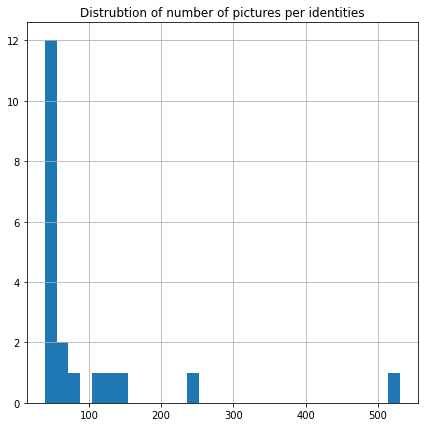

In [3]:
correspondance_df = create_correspondance_df(path_to_pictures)
tmp = correspondance_df.groupby("label").count().sort_values("id").tail(20)
multi = tmp.index
correspondance_df = correspondance_df[correspondance_df['label'].isin(list(multi))].reset_index().drop("index",axis = 1)

print("Number of identities  in the training set %i" % correspondance_df.describe().loc["unique","id"])
print("Number of images in the training set %i" % correspondance_df.describe().loc["count","face"])
print("-----------------------------------------------------------------------")
fig, ax = plt.subplots(1,1, figsize = (7,7))
correspondance_df.groupby("id").count()['face'].hist(bins = 30,ax = ax);
ax.set_title("Distrubtion of number of pictures per identities");

- The dataset is still imabalanced, one of the class has more than 500 picture as all the other one have less than 250.
- The majority class corresponds to George W Bush

In [4]:
#Shuffle the dataset 
correspondance_df = correspondance_df.sample(frac =1.0,replace = False)
list_IDs = path_to_pictures + "/" + correspondance_df.id + "/" + correspondance_df.face
labelencoder = LabelEncoder()
correspondance_df["label"] = labelencoder.fit_transform(correspondance_df["label"]) 
labels = correspondance_df.label

n_classes =  pd.unique(correspondance_df.label).shape[0]



## Preprocessing pipeline
The pipeline consists in :
- Detect the faces using an haar cascade method
- Crop those faces 
- Resize them and normalize the image


### Sample of of the dataset

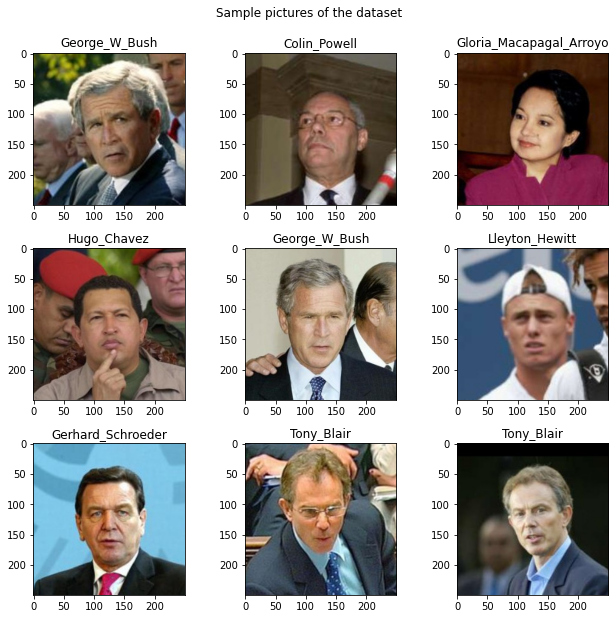

In [5]:
def plot_sample(path_to_pictures, correspondance_df, x = 3, y = 3):
    """
    Plot a x*y image randomly chosen from the correspondance matrix  
    args :
    path_to_pictures (str) : Path to folder where the pictures are located
    correspondance_df (pd.DataFrame) : The DataFrame with correspondances
    x (int): The number of plot in horizontal axis
    y (int): The number of plot in vertical axis
    returns :

    """
    fig, axs = plt.subplots(x,y,figsize = (x*3,y*3))
    sample = correspondance_df.sample(n=x*y, replace=False)
    index = 0
    for i in range(x):
        for j in range(y):
            folder, img =  list(sample.iloc[index,:2])
            img_path = path_to_pictures + "/" + folder + "/" + img
            img = cv2.imread(img_path)
            RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axs[i][j].imshow(RGB_img)
            axs[i][j].set_title(folder)
            index += 1
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle("Sample pictures of the dataset")
    plt.show()

plot_sample(path_to_pictures,correspondance_df)

### Sample of detected faces

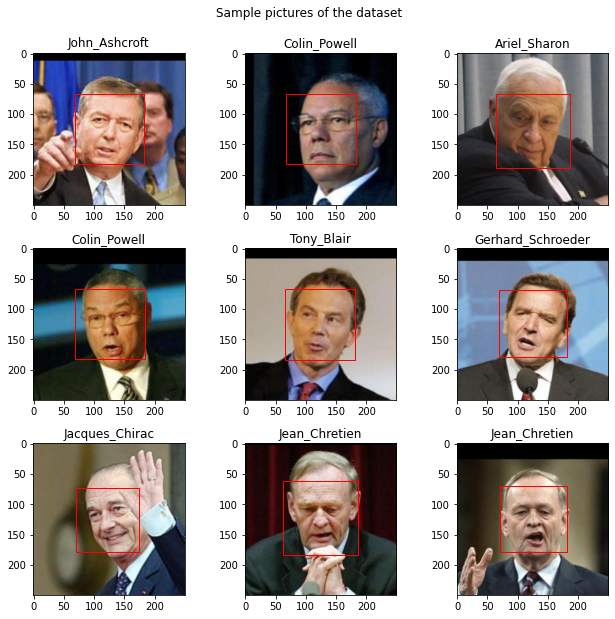

In [6]:
detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
def plot_face_detect_sample(path_to_pictures, correspondance_df, x = 3, y = 3, detector=detector):
    """
    Plot a x*y image randomly chosen from the correspondance matrix  
    args :
    path_to_pictures (str) : Path to folder where the pictures are located
    correspondance_df (pd.DataFrame) : The DataFrame with correspondances
    x (int): The number of plot in horizontal axis
    y (int): The number of plot in vertical axis
    returns :

    """
    
    fig, axs = plt.subplots(x,y,figsize = (x*3,y*3))
    sample = correspondance_df.sample(n=x*y, replace=False)
    index = 0
    for i in range(x):
        for j in range(y):
            folder, img =  list(sample.iloc[index,:2])
            img_path = path_to_pictures + "/" + folder + "/" + img
            img = cv2.imread(img_path)
            RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            rec = detector.detectMultiScale(RGB_img)[0]
            axs[i][j].imshow(RGB_img)
            axs[i][j].set_title(folder)
            rect = patches.Rectangle((rec[0],rec[1]),rec[2],rec[3],linewidth=1,edgecolor='r',facecolor='none')
            axs[i][j].add_patch(rect)
            index += 1
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle("Sample pictures of the dataset")
    plt.show()

plot_face_detect_sample(path_to_pictures,correspondance_df)



  


### An example of cropped and normalized face

In [7]:

sample = correspondance_df.sample(n = 1, replace=False)

folder, img =  list(sample.iloc[0,:2])
img_path = path_to_pictures + "/" + folder + "/" + img
random_image = cv2.imread(img_path)
random_image = cv2.cvtColor(random_image, cv2.COLOR_BGR2RGB)


def crop_face(img, detector, width = 299, height = 299):
    """
    Crop faces of an image
    args:
    img(np.array) : A tri dimentionnal array with the pixels of the original image
    detector (cv2.detector): An cv2 face detector
    width (int) : The desired face width
    height (int) : The desired face height
    returns:
    crop_img(np.array) : The cropped face 
    """
    try:
        face_x, face_y, face_width, face_height  = detector.detectMultiScale(img)[0]
        crop_img = img[face_y:face_y+face_height, face_x:face_x+face_width]
        crop_img = cv2.resize(crop_img, (width,height))
    except:
        crop_img = cv2.resize(img, (width,height))
    return(crop_img)


def normalize_face(crop_face, center = 127.5, scale = 128):
    """
    Normalize the image according to the protocol explained
    args:
    crop_face(np.array) : A tri dimentionnal array with the pixels of the face image
    returns:
    norm_image(np.array) : A tri dimentionnal array with the normalized pixels 
    """
    norm_image = (crop_face - center) / scale
    return(norm_image)



#### Original

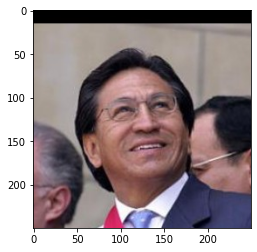

In [8]:
plt.imshow(random_image)

#### Cropped

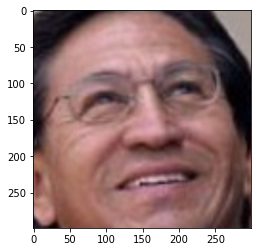

In [9]:
crop = crop_face(random_image,detector)
plt.imshow(crop)


#### Normalized

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


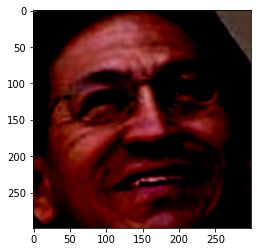

In [10]:
norm = normalize_face(crop)
plt.imshow(norm)

We summurized all those steps into the `data_generator.py` module in the `dependencies` folder. It would have been nice to add a face alignement step and a data augmentation step, but as we were poor in computationnal power we sticked to those basic step. 

In [11]:
from dependencies.data_generator import *
from dependencies.keras_losses import *


We design a small dataset that which will be used to visualize our embedings

In [12]:
sample_df = correspondance_df.sample(frac = 0.15).reset_index()
X = []

for i in range(sample_df.shape[0]):
    folder = sample_df.loc[i,"id"]
    img = sample_df.loc[i,"face"]
    img_path = path_to_pictures + "/" + folder + "/" + img
    random_image = cv2.imread(img_path)
    random_image = cv2.cvtColor(random_image, cv2.COLOR_BGR2RGB)
    crop = crop_face(random_image,detector)
    norm = normalize_face(crop)
    X.append(norm)
X = np.array(X)

Here are some useful function for the training of our models and the embeded representations

In [13]:
def create_embeding_model(dict_models, index_embed = 6, one_input = False ):
    """
    Creates the face embeding model dictionnary associated to the models
    args:
        dict_models (dict): a dictionnary of models
    """
    dict_embed = {}
    for version, value in dict_models.items():
        if one_input:
            new_model = Model(inputs=value.input, outputs=value.layers[index_embed].output)
        else:
            new_model = Model(inputs=value.input[0], outputs=value.layers[index_embed].output)
        dict_embed[version] = new_model
    return dict_embed

def plot_histories(dict_history):
    """
    Plot histories of the models
    """
    fig , ax = plt.subplots(len(dict_history),2,figsize = (10,7))
    i=0
    for version, value in dict_history.items():
        ax[i][0].plot(value.history['loss'])
        ax[i][0].set_title("Loss of the model : " + version)
        ax[i][0].grid()
        ax[i][1].plot(value.history['accuracy'])
        ax[i][1].set_title("Accuracy of the model : " + version)
        ax[i][1].grid()
        i+=1
    plt.tight_layout()
    plt.show()

def plot_embeding(embed_models, X,labels):
    fig , ax = plt.subplots(len(embed_models),1,figsize = (15,15))
    i=0
    for version, value in embed_models.items():
        alg = TSNE(n_components=2)
        embed = value.predict(X)
        X_embedded = alg.fit_transform(embed)
        sns.scatterplot(
        x=X_embedded[:,0], y=X_embedded[:,1],
        hue = labels,
        alpha=0.7,ax = ax[i])
        i += 1
        plt.show()


### Model architechture and training 
The models loss are explained in the readme. For the fairest comparison we could have done given our computationnal power, we tried the three losses on the same architechure : 
- A pretrained architechture of mobilenet (really light in term of parameters)
- Followed by an average pooling (to reduce the number of parameters)
- Followed by the embbeding face layer of `254` neurones with a dropout rate of `25 %` (as the dataset is imbalanced, we were affraid of an overspecialization of our networks)
To finish all those networks have their specific prediction layer and their loss layer.
We tested each networks with a learning rate starting at `10**-3` and two combinasions of their loss specific hyperparameters.



In [14]:
batch_size = 128
epochs = 25
e_size = 2**8
drop = 0.25



#### Sphere face models
We tested the model with to combinations for `s` and `m` (resp (30,20) and (1.25,.75))

In [298]:
models_sphere = {}
histo_sphere = {}

In [299]:

i = 1
for tab in [(30,1.25),(20,0.75)]:
    s = tab[0]
    m = tab[1]
    label = Input(shape=(n_classes,))
    inp = Input(shape = (299, 299, 3))
    # create the base pre-trained model
    base_arch = MobileNetV2(weights='imagenet', include_top=False,input_shape=(299, 299, 3))
    for layer in base_arch.layers:
        layer.trainable = False


    x = base_arch(inp)
    x = MaxPooling2D(pool_size=(10, 10))(x)
    x = Flatten()(x)
    x = Dense(e_size, name='embed',activation = "relu")(x)
    x = Dropout(drop)(x)
    x = BatchNormalization()(x)
    output = SphereFace(n_classes=n_classes,s=s, m=m)([x, label])
    model = Model(inputs=(inp, label),
                outputs=output)
    optimizer = keras.optimizers.Adam(learning_rate=10**-3)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics = "accuracy")
    history = model.fit(DataGenerator(list_IDs, labels, batch_size=batch_size, n_classes= n_classes),epochs = epochs)
    model.save('models/sphere_face/sphere_face_v_'+str(i))
    models_sphere[str(i)] = model
    histo_sphere[str(i)] = history
    i +=1    

Epoch 1/25
14/14 [==============================] - 44s 3s/step - loss: 15.7556 - accuracy: 0.0000e+00
Epoch 2/25
14/14 [==============================] - 40s 3s/step - loss: 14.9496 - accuracy: 0.0000e+00
Epoch 3/25
14/14 [==============================] - 39s 3s/step - loss: 14.6292 - accuracy: 0.0000e+00
Epoch 4/25
14/14 [==============================] - 39s 3s/step - loss: 13.6826 - accuracy: 0.0000e+00
Epoch 5/25
14/14 [==============================] - 39s 3s/step - loss: 13.8428 - accuracy: 0.0000e+00
Epoch 6/25
14/14 [==============================] - 39s 3s/step - loss: 13.4336 - accuracy: 0.0000e+00
Epoch 7/25
14/14 [==============================] - 40s 3s/step - loss: 12.7529 - accuracy: 0.0000e+00
Epoch 8/25
14/14 [==============================] - 40s 3s/step - loss: 12.6367 - accuracy: 0.0000e+00
Epoch 9/25
14/14 [==============================] - 40s 3s/step - loss: 12.8392 - accuracy: 0.0000e+00
Epoch 10/25
14/14 [==============================] - 41s 3s/step - loss: 

#### Training and accuracy for the sphereface model

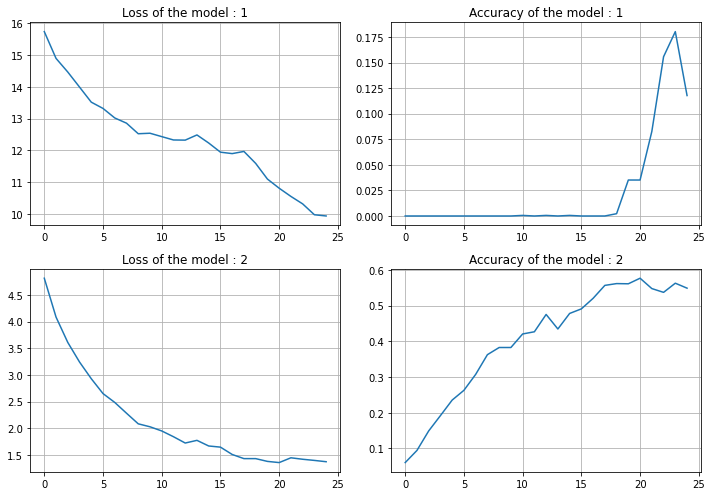

In [377]:
plot_histories(histo_sphere)

- The losses and accuracies have a standard behaviour.
- We can see that the first model pains more to reduce the losses (it seems natural the hyperparameters are higher)
- The second models achieves quite good results on the training set (60% accuracy)

#### Embedings for the sphereface model
As our space is 258 dimensionnal we used TSNE to visualize it in two dimensions

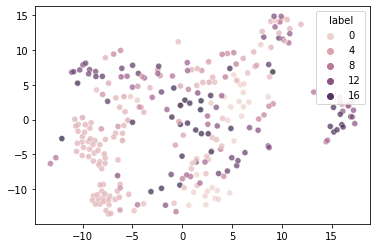

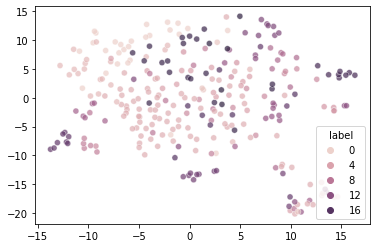

In [388]:
embed_models = create_embeding_model(models_sphere,index_embed = 6)
#plot_embeding(embed_models["2"], X,sample_df.label, alg = PCA(n_components=2))

alg = TSNE(n_components=2)
embed = embed_models["1"].predict(X)
X_embedded = alg.fit_transform(embed)
sns.scatterplot(
x=X_embedded[:,0], y=X_embedded[:,1],
hue = sample_df.label,
alpha=0.7)
plt.show()
alg = TSNE(n_components=2)
embed = embed_models["2"].predict(X)
X_embedded = alg.fit_transform(embed)
sns.scatterplot(
x=X_embedded[:,0], y=X_embedded[:,1],
hue = sample_df.label,
alpha=0.7)
plt.show()

The embedings are not really representatives. They can be several reasons to it :
 - The models are not enought trained
 - The 2D representation is not representative enought for our embeddings

#### Center loss models
We tested the model with to combinations for two `lambdas` (0.1 and 0.4)

In [300]:
models_center = {}
histo_center = {}

In [301]:

i=1
for lambd in [0.1,0.4]:
    alpha = 0.5
    label = Input(shape=(n_classes,))
    inp = Input(shape = (299, 299, 3))
    # create the base pre-trained model
    base_arch = MobileNetV2(weights='imagenet', include_top=False,input_shape=(299, 299, 3))
    for layer in base_arch.layers:
        layer.trainable = False


    x = base_arch(inp)
    x = MaxPooling2D(pool_size=(10, 10))(x)
    x = Flatten()(x)
    x = Dense(e_size, name='embed', activation='relu')(x)
    x = Dropout(drop)(x)
    x = BatchNormalization()(x)
    prediction = Dense(n_classes, activation='softmax')(x)
    side_output = CenterLossLayer(n_classes= n_classes, embeding_size = e_size, alpha=alpha, name='centerlosslayer')([x, label])
    optimizer = keras.optimizers.Adam(learning_rate=10**-3)
    model = Model(inputs=[inp, label], outputs=[prediction, side_output])

    def zero_loss(y_true, y_pred):
        return 0.5 * K.sum(y_pred, axis=0)

    model.compile(optimizer=optimizer, loss=['categorical_crossentropy', zero_loss],
                      loss_weights=[1, lambd], metrics ="accuracy")
    
    history = model.fit_generator(DataGeneratorCenter(list_IDs, labels, batch_size= batch_size, n_classes= n_classes),epochs = epochs)
    model.save('models/center_loss/center_loss_v_'+str(i))
    models_center[str(i)] = model
    histo_center[str(i)] = history
    i +=1    
    print("Finished")
    


C:\Users\LoicB\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
14/14 [==============================] - 46s 3s/step - loss: 768.6209 - dense_14_loss: 3.3586 - centerlosslayer_loss: 7652.6233 - dense_14_accuracy: 0.0493 - centerlosslayer_accuracy: 0.0000e+00
Epoch 2/25
14/14 [==============================] - 41s 3s/step - loss: 261.8130 - dense_14_loss: 3.0342 - centerlosslayer_loss: 2587.7873 - dense_14_accuracy: 0.0729 - centerlosslayer_accuracy: 0.0000e+00
Epoch 3/25
14/14 [==============================] - 41s 3s/step - loss: 186.9711 - dense_14_loss: 3.0247 - centerlosslayer_loss: 1839.4639 - dense_14_accuracy: 0.0600 - centerlosslayer_accuracy: 0.0000e+00
Epoch 4/25
14/14 [==============================] - 41s 3s/step - loss: 98.7311 - dense_14_loss: 2.9756 - centerlosslayer_loss: 957.5555 - dense_14_accuracy: 0.0655 - centerlosslayer_accuracy: 0.0000e+00
Epoch 5/25
14/14 [==============================] - 41s 3s/step - loss: 61.0075 - dense_14_loss: 2.9473 - centerlosslayer_loss: 580.6021 - dense_14_accuracy: 0.0928 - centerlossl

C:\Users\LoicB\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
14/14 [==============================] - 50s 3s/step - loss: 3562.8157 - dense_15_loss: 3.4541 - centerlosslayer_loss: 8898.4047 - dense_15_accuracy: 0.0381 - centerlosslayer_accuracy: 0.0000e+00
Epoch 2/25
14/14 [==============================] - 202s 15s/step - loss: 1640.4601 - dense_15_loss: 3.1754 - centerlosslayer_loss: 4093.2114 - dense_15_accuracy: 0.0529 - centerlosslayer_accuracy: 0.0000e+00
Epoch 3/25
14/14 [==============================] - 43s 3s/step - loss: 1125.0138 - dense_15_loss: 3.0761 - centerlosslayer_loss: 2804.8443 - dense_15_accuracy: 0.0568 - centerlosslayer_accuracy: 0.0000e+00
Epoch 4/25
14/14 [==============================] - 43s 3s/step - loss: 661.8950 - dense_15_loss: 3.0156 - centerlosslayer_loss: 1647.1986 - dense_15_accuracy: 0.0889 - centerlosslayer_accuracy: 0.0000e+00
Epoch 5/25
14/14 [==============================] - 41s 3s/step - loss: 316.0331 - dense_15_loss: 2.9691 - centerlosslayer_loss: 782.6600 - dense_15_accuracy: 0.0809 - cen

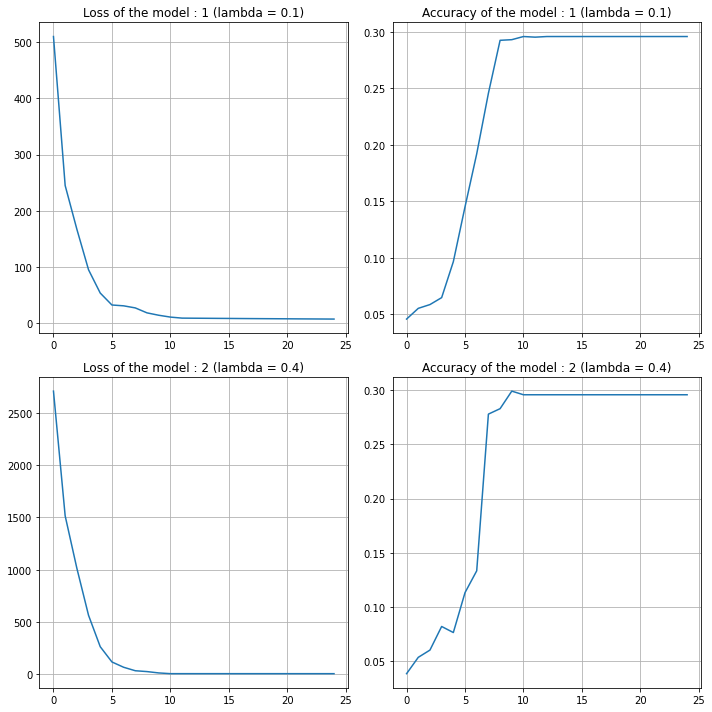

In [397]:
fig , ax = plt.subplots(len(histo_center),2,figsize = (10,10))
ax[0][0].plot(histo_center["1"].history['loss'])
ax[0][0].set_title("Loss of the model : " + "1" + " (lambda = 0.1)")
ax[0][0].grid()
ax[0][1].plot(histo_center["1"].history['dense_14_accuracy'])
ax[0][1].set_title("Accuracy of the model : " + "1" + " (lambda = 0.1)")
ax[0][1].grid()
ax[1][0].plot(histo_center["2"].history['loss'])
ax[1][0].set_title("Loss of the model : " + "2"+ " (lambda = 0.4)")
ax[1][0].grid()
ax[1][1].plot(histo_center["2"].history['dense_15_accuracy'])
ax[1][1].set_title("Accuracy of the model : " + "2" + " (lambda = 0.4)")
ax[1][1].grid()
plt.tight_layout()

plt.show()

As we can see the two accuracies cap at 30% (which is the frequency of the majority class). We can think that the models overfit.
#### Embedings for the centerloss models
As our space is 258 dimensionnal we used TSNE to visualize it in two dimensions

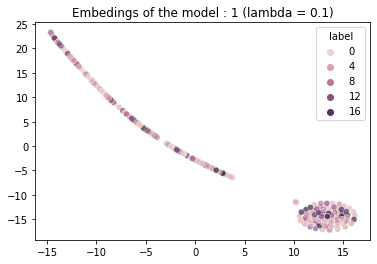

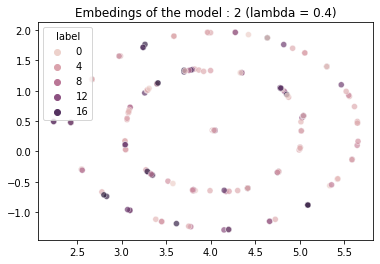

In [398]:
embed_models = create_embeding_model(models_center,index_embed = 6)
#plot_embeding(embed_models["2"], X,sample_df.label, alg = PCA(n_components=2))

alg = TSNE(n_components=2)
embed = embed_models["1"].predict(X)
X_embedded = alg.fit_transform(embed)
sns.scatterplot(
x=X_embedded[:,0], y=X_embedded[:,1],
hue = sample_df.label,
alpha=0.7)
plt.title("Embedings of the model : " + str(1) + " (lambda = 0.1)")
plt.show()

alg = TSNE(n_components=2)
embed = embed_models["2"].predict(X)
X_embedded = alg.fit_transform(embed)
sns.scatterplot(
x=X_embedded[:,0], y=X_embedded[:,1],
hue = sample_df.label,
alpha=0.7)
plt.title("Embedings of the model : " + str(2) + " (lambda = 0.4)")
plt.show()

The model seems to try to separate the embeddings, however those 2D vizualisation are not convincing. 

#### Triplet loss models
We tested the model with two `alpha` (0.1 and 0.4)

In [23]:
models_triplet = {}
histo_triplet = {}

In [24]:

i = 1
for alpha in [0.1,0.4]:
    label = Input(shape=(n_classes,))
    inp = Input(shape = (299, 299, 3))
    # create the base pre-trained model
    base_arch = MobileNetV2(weights='imagenet', include_top=False,input_shape=(299, 299, 3))
    for layer in base_arch.layers:
        layer.trainable = False
    
    x = base_arch(inp)
    x = MaxPooling2D(pool_size=(10, 10))(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(e_size, kernel_initializer='he_normal', activation='relu')(x)
    x = Dropout(drop)(x)
    predictions = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x)

    model = Model(inputs=inp,
                  outputs=predictions)

    model.compile(optimizer='adam', loss=tfa.losses.TripletSemiHardLoss())

    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=0,
        zoom_range=0
    )

    generator = datagen.flow_from_directory(
        path_to_pictures,
        target_size = (299,299),
        class_mode="sparse",
        batch_size=batch_size,
        classes = list(pd.unique(correspondance_df.id))   
    )
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss=tfa.losses.TripletSemiHardLoss(margins = alpha), metrics = "accuracy")
    
    history = model.fit(generator,epochs=epochs)
    models_triplet[str(i)] = model
    histo_triplet[str(i)] = history
    model.save('models/triplet_loss/triplet_loss_v_'+str(i))
    i +=1

Found 1906 images belonging to 20 classes.
Epoch 1/30
15/15 [==============================] - 24s 397ms/step - loss: 0.9974 - accuracy: 0.0022
Epoch 2/30
15/15 [==============================] - 5s 337ms/step - loss: 0.9967 - accuracy: 0.0029
Epoch 3/30
15/15 [==============================] - 5s 337ms/step - loss: 0.9959 - accuracy: 0.0045
Epoch 4/30
15/15 [==============================] - 5s 342ms/step - loss: 0.9948 - accuracy: 0.0022
Epoch 5/30
15/15 [==============================] - 5s 338ms/step - loss: 0.9935 - accuracy: 0.0045
Epoch 6/30
15/15 [==============================] - 5s 340ms/step - loss: 0.9918 - accuracy: 0.0052
Epoch 7/30
15/15 [==============================] - 5s 347ms/step - loss: 0.9889 - accuracy: 0.0042
Epoch 8/30
15/15 [==============================] - 5s 337ms/step - loss: 0.9871 - accuracy: 0.0032
Epoch 9/30
15/15 [==============================] - 5s 339ms/step - loss: 0.9824 - accuracy: 0.0013
Epoch 10/30
15/15 [==============================] - 5s 

#### Triplet loss losses analyses


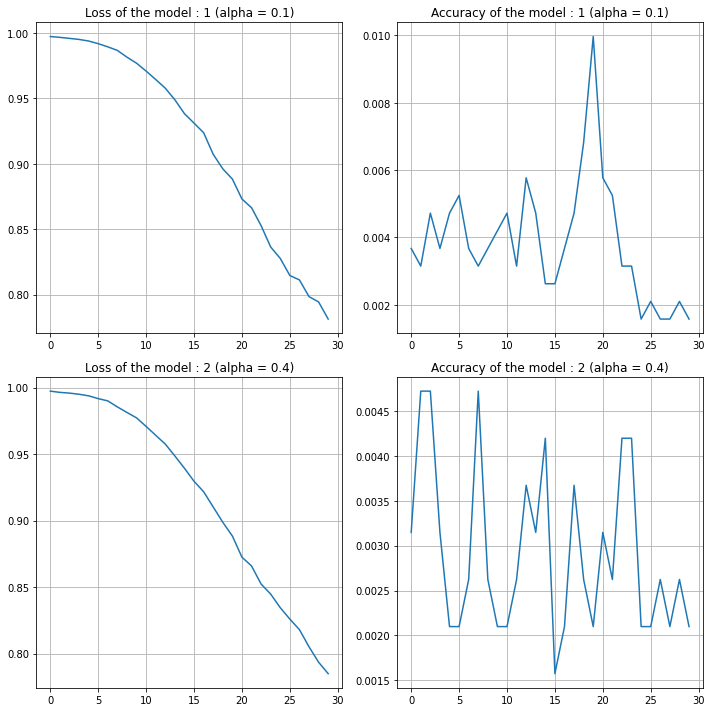

In [28]:

fig , ax = plt.subplots(len(histo_triplet),2,figsize = (10,10))
ax[0][0].plot(histo_triplet["1"].history['loss'])
ax[0][0].set_title("Loss of the model : " + "1" + " (alpha = 0.1)")
ax[0][0].grid()
ax[0][1].plot(histo_triplet["1"].history['accuracy'])
ax[0][1].set_title("Accuracy of the model : " + "1" + " (alpha = 0.1)")
ax[0][1].grid()
ax[1][0].plot(histo_triplet["2"].history['loss'])
ax[1][0].set_title("Loss of the model : " + "2"+ " (alpha = 0.4)")
ax[1][0].grid()
ax[1][1].plot(histo_triplet["2"].history['accuracy'])
ax[1][1].set_title("Accuracy of the model : " + "2" + " (alpha = 0.4)")
ax[1][1].grid()
plt.tight_layout()


Even if the loss decrease the model accuracy on the training data does not increase a lot.

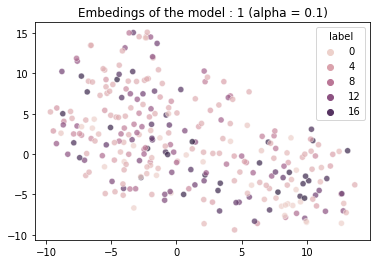

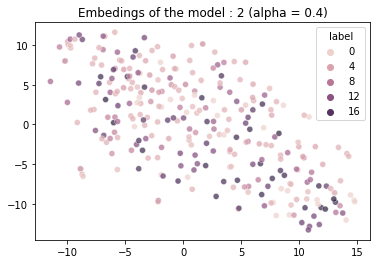

In [395]:
embed_models = create_embeding_model(models_triplet,index_embed =7,one_input = True)


alg = TSNE(n_components=2)
embed = embed_models["1"].predict(X)
X_embedded = alg.fit_transform(embed)
sns.scatterplot(
x=X_embedded[:,0], y=X_embedded[:,1],
hue = sample_df.label,
alpha=0.7)
plt.title("Embedings of the model : " + str(1) + " (alpha = 0.1)")
plt.show()
alg = TSNE(n_components=2)
embed = embed_models["2"].predict(X)
X_embedded = alg.fit_transform(embed)
sns.scatterplot(
x=X_embedded[:,0], y=X_embedded[:,1],
hue = sample_df.label,
alpha=0.7)
plt.title("Embedings of the model : " + str(2) + " (alpha = 0.4)")
plt.show()